In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
df = pd.read_pickle("../run/Taa/df-grouped-sim.pkl")
df = df[(df.model == 'propwaves') & (df.noise == 1)].copy()

In [3]:
def add_params(df):
    df['uslow'] = 0.
    df['ufast'] = 0.
    df['patch_size'] = 0.
    df['simfreq'] = 0.

    model = 'propwaves'
    noise = 1
    for sid in range(1, 51):
        subject = f"id{sid:03d}"
        print(subject, end=" ", flush=True)
        conf = pd.read_pickle(f"../run/Taa/simulations/configs_{subject}_{model}_{noise}.pkl")
        for i, row in conf.iterrows():
            mask = (df.subject == subject) & (df.rec == i)
            df.loc[mask, ['uslow', 'ufast', 'patch_size', 'simfreq']] = (row.uslow, np.abs(row.ufast),
                                                                         row.patch_size, row.freq)
            
add_params(df)
df['lamb'] = df.ufast / df.simfreq

id001 id002 id003 id004 id005 id006 id007 id008 id009 id010 id011 id012 id013 id014 id015 id016 id017 id018 id019 id020 id021 id022 id023 id024 id025 id026 id027 id028 id029 id030 id031 id032 id033 id034 id035 id036 id037 id038 id039 id040 id041 id042 id043 id044 id045 id046 id047 id048 id049 id050 

In [4]:
def get_percentiles(df, params, lims, nbins, features):
    bincenters = {}
    p05 = {(p, f): np.zeros(nbins) for f in features for p in params}
    avg = {(p, f): np.zeros(nbins) for f in features for p in params}
    p95 = {(p, f): np.zeros(nbins) for f in features for p in params}    
    
    for param, lim in zip(params, lims):
        bins = np.linspace(lim[0], lim[1], nbins + 1)        
        bincenters[param] = (bins[1:] + bins[:-1])/2        
    
        for i in range(nbins):
            dff = df[(df[param] >= bins[i]) & (df[param] < bins[i+1])]

            for feature in features:
                p05[(param, feature)][i] = np.percentile(dff[feature], 5)
                avg[(param, feature)][i] = np.mean(dff[feature])
                p95[(param, feature)][i] = np.percentile(dff[feature], 95)
            
    return bincenters, p05, avg, p95


params = ['uslow', 'patch_size', 'ufast', 'simfreq']
param_names = ['Spread velocity [mm/s]', 'Patch size [mm^2]', 'Wave velocity [mm/s]', 'Frequency [Hz]']
param_lims = [(0.5, 4.0), (400, 2500), (100., 500.), (4, 13)]

features = ['tdur', 'tfr_slope', 'tfr_r2', 'pca_ve1', 'pca_ve2ac']
feature_names = ['Duration [s]', 'Slope [mm/s]', 'R2', 'PCA VE1', 'PCA VE2']

bins, p05, avg, p95 = get_percentiles(df, params, param_lims, 10, features)

## Plot

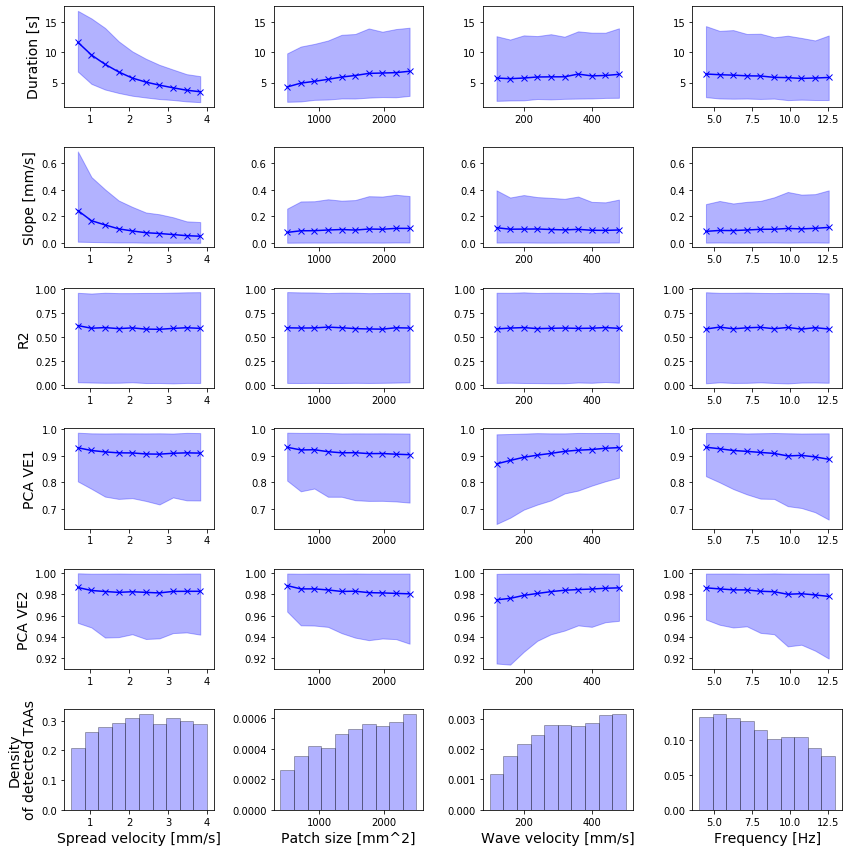

In [5]:
nfeat = len(features)
npars = len(params)

plt.figure(figsize=(12, 12))

axes = np.zeros((nfeat+1, npars), dtype=object)

for i, feature in enumerate(features):
    for j, param in enumerate(params):
        axes[i, j] = plt.subplot2grid((nfeat+1, npars), (i, j),
                                      sharex=None if i == 0 else axes[0, j], sharey=None if j == 0 else axes[i, 0])
        
        plt.plot(bins[param], avg[(param, feature)], 'bx-')
        plt.fill_between(bins[param], p05[(param, feature)], p95[(param, feature)], color='b', alpha=0.3)
        
        if j == 0:
            plt.ylabel(feature_names[i], fontsize=14)

for j, param in enumerate(params):
    axes[len(features), j] = plt.subplot2grid((nfeat+1, npars), (nfeat, j), sharex=axes[0, j]) 
                                             #     ,sharey=None if j == 0 else axes[nfeat, 0])
    plt.hist(df[param], bins=10, color='b', alpha=0.3, ec='k', density=True)
    plt.xlabel(param_names[j], fontsize=14)
    if j == 0:
        plt.ylabel("Density\nof detected TAAs", fontsize=14)
    
            
plt.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.98, hspace=0.4, wspace=0.4)
plt.savefig("figs/param-features.pdf")